## Q1. Install the package

To get started with MLflow you'll need to install the appropriate Python package.

For this we recommend creating a separate Python environment, for example, you can use [conda environments](https://docs.conda.io/projects/conda/en/latest/user-guide/getting-started.html#managing-envs), 
and then install the package there with `pip` or `conda`.

Once you installed the package, run the command `mlflow --version` and check the output.

What's the version that you have?

ANS: `mlflow, version 2.3.2`

In [10]:
!mlflow --version

mlflow, version 2.3.2


## Q2. Download and preprocess the data

We'll use the Green Taxi Trip Records dataset to predict the amount of tips for each trip. 

Download the data for January, February and March 2022 in parquet format from [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

Use the script `preprocess_data.py` located in the folder [`homework`](homework) to preprocess the data.

The script will:

* load the data from the folder `<TAXI_DATA_FOLDER>` (the folder where you have downloaded the data),
* fit a `DictVectorizer` on the training set (January 2022 data),
* save the preprocessed datasets and the `DictVectorizer` to disk.

Your task is to download the datasets and then execute this command:

```
python preprocess_data.py --raw_data_path <TAXI_DATA_FOLDER> --dest_path ./output
```

Tip: go to `02-experiment-tracking/homework/` folder before executing the command and change the value of `<TAXI_DATA_FOLDER>` to the location where you saved the data.

So what's the size of the saved `DictVectorizer` file?

* 54 kB
* 154 kB ✔
* 54 MB
* 154 MB


In [11]:
dataset_link_1 = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet"
dataset_link_2 = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet"
dataset_link_3 = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-03.parquet"

In [12]:
!pwd

/home/prabin_nayak/Workspace/mlops_zoomcamp_2023_repo/cohorts/2023/02-experiment-tracking/homework


In [14]:
#!wget $dataset_link_1
!wget -P "../../02-experiment-tracking/data/" $dataset_link_1

!wget -P "../../02-experiment-tracking/data/" $dataset_link_2

!wget -P "../../02-experiment-tracking/data/" $dataset_link_3

--2023-05-28 14:08:48--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.161.108.184, 18.161.108.231, 18.161.108.141, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.161.108.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1254291 (1.2M) [binary/octet-stream]
Saving to: ‘../../02-experiment-tracking/data/green_tripdata_2022-01.parquet’

green_tripdata_2022 100%[===================>]   1.20M  1.69MB/s    in 0.7s    

2023-05-28 14:08:49 (1.69 MB/s) - ‘../../02-experiment-tracking/data/green_tripdata_2022-01.parquet’ saved [1254291/1254291]

--2023-05-28 14:08:50--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.161.108.184, 18.161.108.231, 18.161.108.141, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci

In [2]:
"""
python preprocess_data.py --raw_data_path "../data/" --dest_path ./output

"""

'\npython preprocess_data.py --raw_data_path "home/prabin_nayak/Workspace/mlops_zoomcamp_2023_repo/02-experiment-tracking/data" --dest_path ./output\n'

## Q3. Train a model with autolog

We will train a `RandomForestRegressor` (from Scikit-Learn) on the taxi dataset.

We have prepared the training script `train.py` for this exercise, which can be also found in the folder `homework`. 

The script will:

* load the datasets produced by the previous step,
* train the model on the training set,
* calculate the RMSE score on the validation set.

Your task is to modify the script to enable **autologging** with MLflow, execute the script and then launch the MLflow UI to check that the experiment run was properly tracked. 

Tip 1: don't forget to wrap the training code with a `with mlflow.start_run():` statement as we showed in the videos.

Tip 2: don't modify the hyperparameters of the model to make sure that the training will finish quickly.

What is the value of the `max_depth` parameter:

* 4
* 6
* 8
* 10 ✔


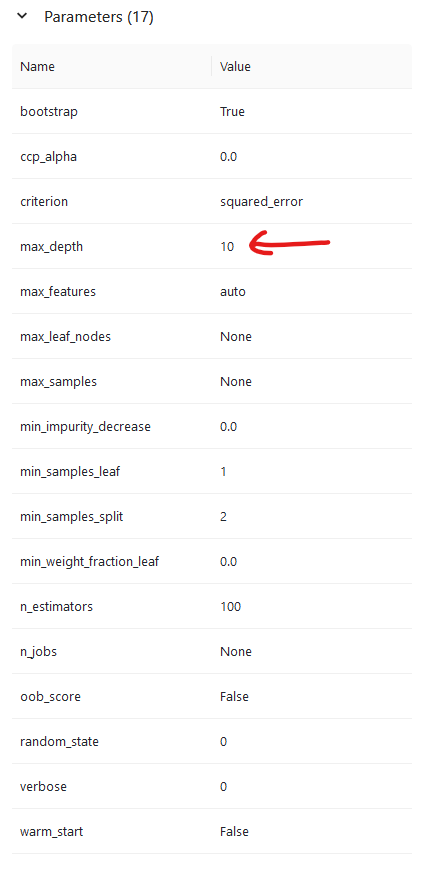

### Code for Q3

In [ ]:
import os
import pickle
import click

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import mlflow

def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


@click.command()
@click.option(
    "--data_path",
    default="./output",
    help="Location where the processed NYC taxi trip data was saved"
)
def run_train(data_path: str):
    
    mlflow.autolog()
    
    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

    rf = RandomForestRegressor(max_depth=10, random_state=0)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)


if __name__ == '__main__':
    mlflow.set_tracking_uri("sqlite:///mlflow.db")
    mlflow.set_experiment("green-nyc-taxi-experiment")
    run_train()


## Launch the tracking server locally for MLflow

Now we want to manage the entire lifecycle of our ML model. In this step, you'll need to launch a tracking server. This way we will also have access to the model registry. 

In case of MLflow, you need to:

* launch the tracking server on your local machine,
* select a SQLite db for the backend store and a folder called `artifacts` for the artifacts store.

You should keep the tracking server running to work on the next three exercises that use the server.


## Q4. Tune model hyperparameters

Now let's try to reduce the validation error by tuning the hyperparameters of the `RandomForestRegressor` using `optuna`. 
We have prepared the script `hpo.py` for this exercise. 

Your task is to modify the script `hpo.py` and make sure that the validation RMSE is logged to the tracking server for each run of the hyperparameter optimization (you will need to add a few lines of code to the `objective` function) and run the script without passing any parameters.

After that, open UI and explore the runs from the experiment called `random-forest-hyperopt` to answer the question below.

Note: Don't use autologging for this exercise.

The idea is to just log the information that you need to answer the question below, including:

* the list of hyperparameters that are passed to the `objective` function during the optimization,
* the RMSE obtained on the validation set (February 2022 data).

What's the best validation RMSE that you got?

* 1.85
* 2.15
* 2.45 ✔✔✔
* 2.85

### Code for the same

In [ ]:
import os
import pickle
import click
import mlflow
import optuna

from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

mlflow.set_tracking_uri("http://127.0.0.1:5000") 
"""
# as the server is already running so the uri is take from the stacktrac after running the command `mlflow ui --backend-store-uri sqlite:///mlflow.db`
[2023-05-28 15:11:25 +0530] [6944] [INFO] Starting gunicorn 20.1.0
[2023-05-28 15:11:25 +0530] [6944] [INFO] Listening at: http://127.0.0.1:5000 (6944)
[2023-05-28 15:11:25 +0530] [6944] [INFO] Using worker: sync
[2023-05-28 15:11:25 +0530] [6945] [INFO] Booting worker with pid: 6945
[2023-05-28 15:11:25 +0530] [6946] [INFO] Booting worker with pid: 6946
[2023-05-28 15:11:25 +0530] [6947] [INFO] Booting worker with pid: 6947
[2023-05-28 15:11:25 +0530] [6948] [INFO] Booting worker with pid: 6948
"""
mlflow.set_experiment("random-forest-hyperopt")

def load_pickle(filename):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


@click.command()
@click.option(
    "--data_path",
    default="./output",
    help="Location where the processed NYC taxi trip data was saved"
)
@click.option(
    "--num_trials",
    default=10,
    help="The number of parameter evaluations for the optimizer to explore"
)
def run_optimization(data_path: str, num_trials: int):

    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
            'max_depth': trial.suggest_int('max_depth', 1, 20, 1),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10, 1),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4, 1),
            'random_state': 42,
            'n_jobs': -1
        }

        rf = RandomForestRegressor(**params)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        mlflow.log_metric("rmse", rmse)

        return rmse

    sampler = TPESampler(seed=42)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=num_trials)
    """
    here in the above code we are just taking a study with "sampler=TPESampler" and 
    trying to optimizing the objective func
    "objective" func is consisting 
    > of hyper-paramters provided to the Regressor, 
    > then fitting the model, 
    > then pridicting 
    > comparing the true values <> predicted values and returning a rsme
    
    """


if __name__ == '__main__':
    run_optimization()

## Q5. Promote the best model to the model registry

The results from the hyperparameter optimization are quite good. So, we can assume that we are ready to test some of these models in production. 
In this exercise, you'll promote the best model to the model registry. We have prepared a script called `register_model.py`, which will check the results from the previous step and select the top 5 runs. 
After that, it will calculate the RMSE of those models on the test set (March 2022 data) and save the results to a new experiment called `random-forest-best-models`.

Your task is to update the script `register_model.py` so that it selects the model with the lowest RMSE on the test set and registers it to the model registry.

Tips for MLflow:

* you can use the method `search_runs` from the `MlflowClient` to get the model with the lowest RMSE,
* to register the model you can use the method `mlflow.register_model` and you will need to pass the right `model_uri` in the form of a string that looks like this: `"runs:/<RUN_ID>/model"`, and the name of the model (make sure to choose a good one!).

What is the test RMSE of the best model?

* 1.885
* 2.185
* 2.555
* 2.955

```bash
(mlops_zoomcamp_2023) prabin_nayak@DESKTOP-IUPLGMD:~/Workspace/mlops_zoomcamp_2023_repo/cohorts/2023/02-experiment-tracking/homework$ python register_model.py
2023/05/28 16:05:22 INFO mlflow.tracking.fluent: Experiment with name 'random-forest-best-models' does not exist. Creating a new experiment.
Traceback (most recent call last):
  File "/home/prabin_nayak/Workspace/mlops_zoomcamp_2023_repo/cohorts/2023/02-experiment-tracking/homework/register_model.py", line 91, in <module>
    run_register_model()
  File "/home/prabin_nayak/anaconda3/envs/mlops_zoomcamp_2023/lib/python3.9/site-packages/click/core.py", line 1130, in __call__
    return self.main(*args, **kwargs)
  File "/home/prabin_nayak/anaconda3/envs/mlops_zoomcamp_2023/lib/python3.9/site-packages/click/core.py", line 1055, in main
    rv = self.invoke(ctx)
  File "/home/prabin_nayak/anaconda3/envs/mlops_zoomcamp_2023/lib/python3.9/site-packages/click/core.py", line 1404, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/home/prabin_nayak/anaconda3/envs/mlops_zoomcamp_2023/lib/python3.9/site-packages/click/core.py", line 760, in invoke
    return __callback(*args, **kwargs)
  File "/home/prabin_nayak/Workspace/mlops_zoomcamp_2023_repo/cohorts/2023/02-experiment-tracking/homework/register_model.py", line 72, in run_register_model
    train_and_log_model(data_path=data_path, params=run.data.params)
  File "/home/prabin_nayak/Workspace/mlops_zoomcamp_2023_repo/cohorts/2023/02-experiment-tracking/homework/register_model.py", line 32, in train_and_log_model
    params[param] = int(params[param])
KeyError: 'max_depth'
```

WHen trying to execute the register_model.py, getting error `KeyError: 'max_depth'` as there is no max_depth in the previous run

```bash
(mlops_zoomcamp_2023) prabin_nayak@DESKTOP-IUPLGMD:~/Workspace/mlops_zoomcamp_2023_repo/cohorts/2023/02-experiment-tracking/homework$ python hpo.py
[I 2023-05-28 16:23:07,442] A new study created in memory with name: no-name-bc67d1a9-7683-4250-9e9b-dc4a8f652614
[I 2023-05-28 16:23:09,452] Trial 0 finished with value: 2.451379690825458 and parameters: {'n_estimators': 25, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 2.451379690825458.
[I 2023-05-28 16:23:09,751] Trial 1 finished with value: 2.4667366020368333 and parameters: {'n_estimators': 16, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 2.451379690825458.
[I 2023-05-28 16:23:11,657] Trial 2 finished with value: 2.449827329704216 and parameters: {'n_estimators': 34, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 2 with value: 2.449827329704216.
[I 2023-05-28 16:23:12,505] Trial 3 finished with value: 2.460983516558473 and parameters: {'n_estimators': 44, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 2.449827329704216.
[I 2023-05-28 16:23:13,398] Trial 4 finished with value: 2.453877262701052 and parameters: {'n_estimators': 22, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 2 with value: 2.449827329704216.
[I 2023-05-28 16:23:13,847] Trial 5 finished with value: 2.4720122094960733 and parameters: {'n_estimators': 35, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 2 with value: 2.449827329704216.
[I 2023-05-28 16:23:15,508] Trial 6 finished with value: 2.4516421799356767 and parameters: {'n_estimators': 28, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 2.449827329704216.
[I 2023-05-28 16:23:15,738] Trial 7 finished with value: 2.5374040268274087 and parameters: {'n_estimators': 34, 'max_depth': 1, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 2 with value: 2.449827329704216.
[I 2023-05-28 16:23:16,573] Trial 8 finished with value: 2.455971238567075 and parameters: {'n_estimators': 12, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 2 with value: 2.449827329704216.
[I 2023-05-28 16:23:16,791] Trial 9 finished with value: 2.486106021576535 and parameters: {'n_estimators': 22, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 2 with value: 2.449827329704216.
```

HEre the above vlaues should be logged in teh mlflow so that we can access it in the register_model.py